In [7]:
import numpy as np
import cv2
from ex1_utils import *
from ex2_utils import *
import matplotlib.pyplot as plt
from sequence_utils import VOTSequence
from main import *

In [ ]:
def custom_function_1():
    f = np.zeros((100, 100))
    f[50, 50] = 3
    f[50, 80] = 1
    f[80, 50] = 7
    return gausssmooth(f, 10)

In [14]:
def mean_shift(img, window_size=5, max_iter=100, min_diff=1e-4, start=(50,50)):
    xs, ys = [], []

    # kernel = create_epanechnik_kernel(window_size, window_size, 2)
    kernel = np.ones((window_size, window_size))
    
    _start = np.ceil(-window_size/2)
    _stop = window_size // 2 if window_size % 2 == 0 else window_size // 2 + 1
    
    x_coor = np.tile(np.arange(start=_start, stop=_stop, step=1), (window_size,1))
    y_coor = x_coor.T

    x_loc, y_loc = start

    # Start iterations
    for i in range(max_iter):
        patch, _ = get_patch(img, (x_loc, y_loc), (window_size, window_size))

        weights = patch * kernel / window_size
        
        sum_x = np.sum(x_coor * weights)
        sum_y = np.sum(y_coor * weights)
        
        denom = np.sum(weights)
        
        if denom == 0:
            denom = 1
        
        shift_x = sum_x / denom
        shift_y = sum_y / denom
        
        if shift_x < min_diff and shift_y < min_diff:
            break
        
        x_loc += shift_x
        y_loc += shift_y
        
        xs.append(x_loc)
        ys.append(y_loc)
        
        # if i % (max_iter // 10) == 0:
        #     print(f"Iteration {i}: x_loc={x_loc:.2f}, y_loc={y_loc:.2f}")
    
    return x_loc, y_loc, xs, ys

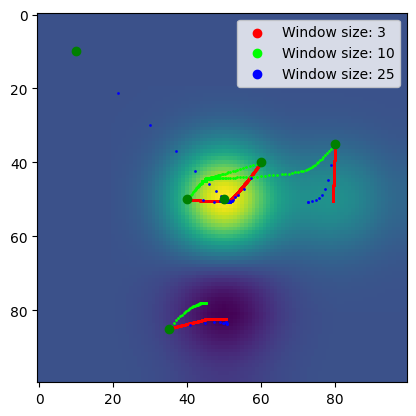

In [15]:
img = generate_responses_1()
img = custom_function_1()
plt.imshow(img)

start_pts = [(80, 35), (50, 50), (40, 50), (60, 40), (35, 85), (10, 10)]

paths = []
window_sizes = [3, 10, 25]
colors = ['#ff0000', '#00ff00', '#0000ff', '#d62728', '#9467bd']#, '#8c564b']#$, '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for ws in window_sizes:
    x_inner_paths = []
    y_inner_paths = []
    for sp in start_pts:
        x, y, xs, ys = mean_shift(img, max_iter=500, start=sp, min_diff=1e-6, window_size=ws)
        
        x_inner_paths.extend(xs + [x])
        y_inner_paths.extend(ys + [y])

    paths.append((x_inner_paths, y_inner_paths))
    
for i, ((xs, ys), c) in enumerate(zip(paths, colors)):
    plt.scatter(xs, ys, c=c, s=1, label=f"Window size: {window_sizes[i]}")

xs_ = ([sp[0] for sp in start_pts])
ys_ = ([sp[1] for sp in start_pts])

plt.scatter(xs_, ys_, c="g")


leg = plt.legend(markerscale=6)

Tracker testing

In [11]:
import time

In [12]:
# set the path to directory where you have the sequences
dataset_path = 'data/' # TODO: set to the dataet path on your disk
sequence = 'ball'  # choose the sequence you want to test

# visualization and setup parameters
win_name = 'Tracking window'
reinitialize = True
show_gt = False
video_delay = 15
font = cv2.FONT_HERSHEY_PLAIN

# create sequence object
sequence = VOTSequence(dataset_path, sequence)
init_frame = 0
n_failures = 0
# create parameters and tracker objects
# parameters = NCCParams()
# tracker = NCCTracker(parameters)
parameters = MSParams()
tracker = MeanShiftTracker(parameters)

time_all = 0

# initialize visualization window
sequence.initialize_window(win_name)
# tracking loop - goes over all frames in the video sequence
frame_idx = 0
img = cv2.imread(sequence.frame(frame_idx))

# initialize tracker (at the beginning of the sequence or after tracking failure)
t_ = time.time()
tracker.initialize(img, sequence.get_annotation(frame_idx, type='rectangle'))
time_all += time.time() - t_
predicted_bbox = sequence.get_annotation(frame_idx, type='rectangle')